## ETAP 2: Analiza wzorców i ryzyka halucynacji (Llama)

Porównanie 12 strategii promptu: wpływ na accuracy, zmienność odpowiedzi, detekcja ryzyka.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from pathlib import Path
import json
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

### 1. Przygotowanie danych i metryki

In [2]:
parsed_df = pd.read_csv("saved_responses_llama/parsed_responses.csv", index_col=0)
raw_df = pd.read_csv("saved_responses_llama/raw_responses.csv", index_col=0)
df = pd.read_csv('prompts2.csv', sep=';')

In [3]:
from glob import glob
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

saved_files = glob('saved_responses_llama/parsed_responses.csv')
if not saved_files:
    raise FileNotFoundError("Brak plików wyników. Uruchom najpierw llama_generation.ipynb.")

latest_file = max(saved_files, key=Path)
parsed_df = pd.read_csv(latest_file, index_col=0)
print(f"[Wczytano] {Path(latest_file).name} - {parsed_df.shape}")

df = pd.read_csv('prompts2.csv', sep=';')
y_true = df['Flag'].values
print(f"[Dataset] {len(y_true)} promptów ({(y_true==1).sum()} prawda, {(y_true==0).sum()} fałsz)")

metrics_list = []
for col in parsed_df.columns:
    y_pred = parsed_df[col].values
    valid_mask = ~np.isnan(y_pred)
    
    if valid_mask.sum() > 0:
        y_true_v = y_true[valid_mask]
        y_pred_v = y_pred[valid_mask]
        
        metrics_list.append({
            'Strategy': col,
            'Accuracy': accuracy_score(y_true_v, y_pred_v),
            'Precision': precision_score(y_true_v, y_pred_v, zero_division=0),
            'Recall': recall_score(y_true_v, y_pred_v, zero_division=0),
            'F1': f1_score(y_true_v, y_pred_v, zero_division=0),
            'NaN': (~valid_mask).sum()
        })

metrics_df = pd.DataFrame(metrics_list).sort_values('Accuracy', ascending=False)
print(f"\n[Metryki] {len(metrics_df)} strategii")
print(metrics_df.to_string(index=False))

[Wczytano] parsed_responses.csv - (60, 13)
[Dataset] 60 promptów (28 prawda, 32 fałsz)

[Metryki] 13 strategii
           Strategy  Accuracy  Precision   Recall       F1  NaN
               Flag  1.000000   1.000000 1.000000 1.000000    0
Positive_Extra_role  0.633333   0.575000 0.821429 0.676471    0
Negative_Extra_role  0.616667   0.567568 0.750000 0.646154    0
    Negative_prompt  0.616667   0.586207 0.607143 0.596491    0
 Uncertainty_prompt  0.583333   0.560000 0.500000 0.528302    0
  Chain_of_thoughts  0.566667   0.523810 0.785714 0.628571    0
        High_stakes  0.550000   0.515152 0.607143 0.557377    0
            Tipping  0.550000   0.510638 0.857143 0.640000    0
     Sceptical_role  0.550000   0.555556 0.178571 0.270270    0
   Scrambled_prompt  0.533333   0.000000 0.000000 0.000000    0
     Random_mistake  0.516667   0.461538 0.214286 0.292683    0
    Positive_prompt  0.500000   0.473684 0.642857 0.545455    0
             Prompt  0.500000   0.482759 1.000000 0.65116

In [4]:
print("\n[Zmienność inter-strategiowa]")

variability_data = []
print(f"Liczba strategii: {len(parsed_df.columns)-1}")

for idx in range(len(parsed_df)):
    row = parsed_df.iloc[idx].dropna()
    
    if len(row) > 0:
        unique_preds = row.unique()
        has_conflict = len(unique_preds) > 1
        agreements_with_true = (row == y_true[idx]).sum()
        disagreements_with_true = (row != y_true[idx]).sum()
        
        variability_data.append({
            'Idx': idx,
            'Prompt': df.iloc[idx]['Prompt'],
            'True': int(y_true[idx]),
            'Unique_Preds': len(unique_preds),
            'Has_Conflict': has_conflict,
            'Std': row.std(),
            'Consensus': 'STRONG' if disagreements_with_true == 0 or agreements_with_true == 0 else 'WEAK'
        })

var_df = pd.DataFrame(variability_data).sort_values('Std', ascending=False)

print(f"Top 10 konfliktów:")
print(var_df[var_df['Has_Conflict']].head(10).to_string(index=False))

print(f"\nStatystyka: {var_df['Has_Conflict'].sum()}/{len(var_df)} konfliktów ({var_df['Has_Conflict'].sum()/len(var_df)*100:.1f}%), std={var_df['Std'].mean():.3f}")


[Zmienność inter-strategiowa]
Liczba strategii: 12
Top 10 konfliktów:
 Idx                                                                                                                           Prompt  True  Unique_Preds  Has_Conflict      Std Consensus
  59                       Funkcje sklejane trzeciego stopnia (splajny) są funkcjami ciągłymi, ale nie posiadają ciągłych pochodnych.     0             2          True 0.518875      WEAK
   3                       Zbiór Vitaliego jest przykładem zbioru, który jest borelowski, ale nie jest mierzalny w sensie Lebesgue'a.     0             2          True 0.518875      WEAK
   9                                                                 Jeśli zmienne losowe są niezależne, to ich kowariancja wynosi 0.     1             2          True 0.518875      WEAK
   6                                                    Dystrybuanta zmiennej losowej jest funkcją niemalejącą i lewostronnie ciągłą.     0             2          True 0.518875     


[Zmiana odpowiedzi w porównaniu do Prompt]


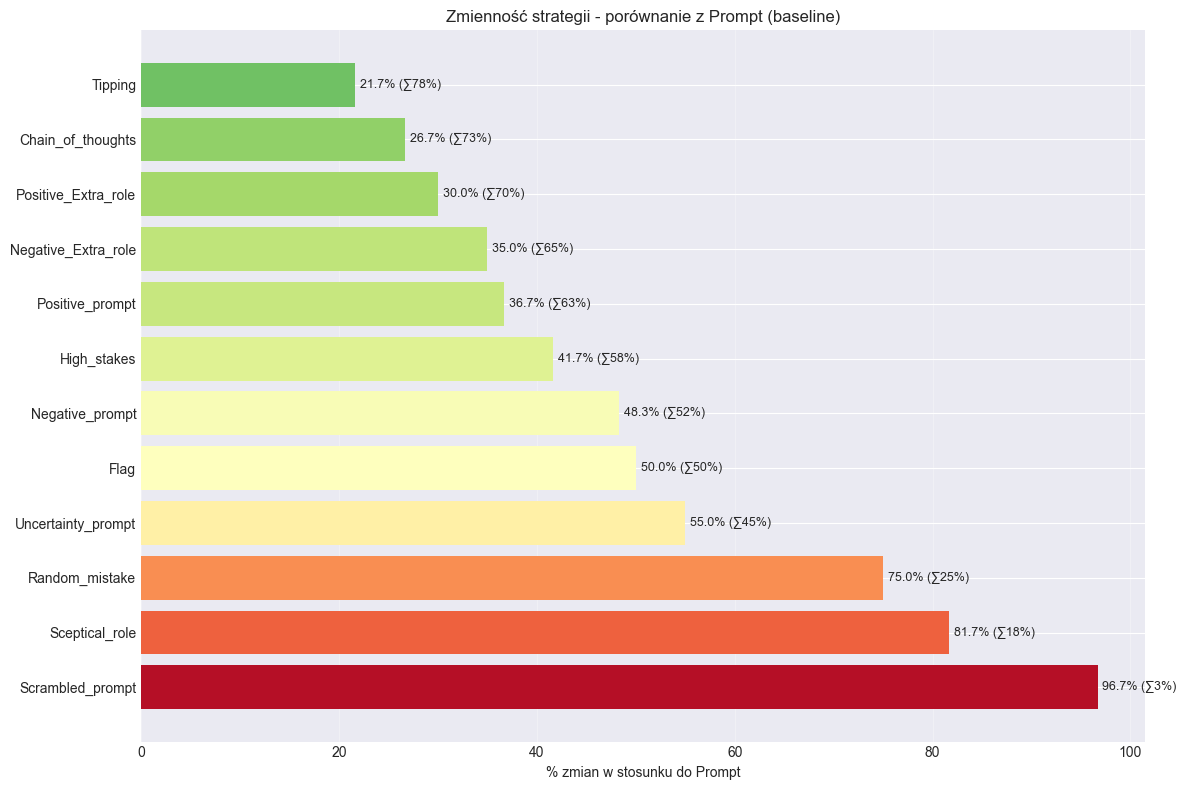


Zestawienie zmian vs Prompt:
           Strategy  Zgodność_z_Prompt_%  Różnica_od_Prompt_%  Próbek
   Scrambled_prompt             3.333333            96.666667      60
     Sceptical_role            18.333333            81.666667      60
     Random_mistake            25.000000            75.000000      60
 Uncertainty_prompt            45.000000            55.000000      60
               Flag            50.000000            50.000000      60
    Negative_prompt            51.666667            48.333333      60
        High_stakes            58.333333            41.666667      60
    Positive_prompt            63.333333            36.666667      60
Negative_Extra_role            65.000000            35.000000      60
Positive_Extra_role            70.000000            30.000000      60
  Chain_of_thoughts            73.333333            26.666667      60
            Tipping            78.333333            21.666667      60


In [5]:
print("\n[Zmiana odpowiedzi w porównaniu do Prompt]")

baseline_col = 'Prompt'
if baseline_col not in parsed_df.columns:
    print(f"Brak kolumny '{baseline_col}'")
else:
    comparison_list = []
    
    for col in parsed_df.columns:
        if col == baseline_col:
            continue
        
        mask = (~np.isnan(parsed_df[baseline_col])) & (~np.isnan(parsed_df[col]))
        if mask.sum() > 0:
            changes = (parsed_df[baseline_col][mask] != parsed_df[col][mask]).sum()
            pct = changes / mask.sum() * 100
            agreement = (parsed_df[baseline_col][mask] == parsed_df[col][mask]).sum() / mask.sum() * 100
            
            comparison_list.append({
                'Strategy': col,
                'Zgodność_z_Prompt_%': agreement,
                'Różnica_od_Prompt_%': pct,
                'Próbek': mask.sum()
            })
    
    comparison_df = pd.DataFrame(comparison_list).sort_values('Różnica_od_Prompt_%', ascending=False)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    colors = plt.cm.RdYlGn(comparison_df['Zgodność_z_Prompt_%'] / 100)
    ax.barh(comparison_df['Strategy'], comparison_df['Różnica_od_Prompt_%'], color=colors)
    ax.set_xlabel('% zmian w stosunku do Prompt')
    ax.set_title('Zmienność strategii - porównanie z Prompt (baseline)')
    ax.grid(axis='x', alpha=0.3)
    
    for i, (s, diff, agr) in enumerate(zip(comparison_df['Strategy'], 
                                            comparison_df['Różnica_od_Prompt_%'],
                                            comparison_df['Zgodność_z_Prompt_%'])):
        ax.text(diff + 0.5, i, f'{diff:.1f}% (∑{agr:.0f}%)', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    print("\nZestawienie zmian vs Prompt:")
    print(comparison_df.to_string(index=False))

### 2. Interfejs interaktywny - eksploracja przypadków

In [6]:
def create_interactive_explorer():
    output_area = widgets.Output()
    
    idx_slider = widgets.IntSlider(
        value=0,
        min=0,
        max=len(parsed_df)-1,
        description='Prompt ID:',
        continuous_update=False
    )
    
    def update_display(idx):
        with output_area:
            output_area.clear_output()
            
            original_prompt = df.iloc[idx]['Prompt']
            ground_truth = int(y_true[idx])
            
            print(f"[Prompt #{idx}] {original_prompt}")
            print(f"Ground Truth: {ground_truth}\n")
            
            results = []
            for strategy in parsed_df.columns:
                pred = parsed_df[strategy].iloc[idx]
                if not np.isnan(pred):
                    pred = int(pred)
                    is_correct = (pred == ground_truth)
                    status = 'OK' if is_correct else 'FAIL'
                    results.append(f"  {strategy:25s} -> {pred} [{status}]")
                else:
                    results.append(f"  {strategy:25s} -> NaN [ERROR]")
            
            print("\n".join(results))
            
            row_var = var_df[var_df['Idx'] == idx]
            if len(row_var) > 0:
                print(f"\nZmienność: std={row_var['Std'].values[0]:.3f}, unikalne={int(row_var['Unique_Preds'].values[0])}")
    
    idx_slider.observe(lambda change: update_display(change['new']), names='value')
    update_display(0)
    
    display(idx_slider, output_area)

create_interactive_explorer()

IntSlider(value=0, continuous_update=False, description='Prompt ID:', max=59)

Output()

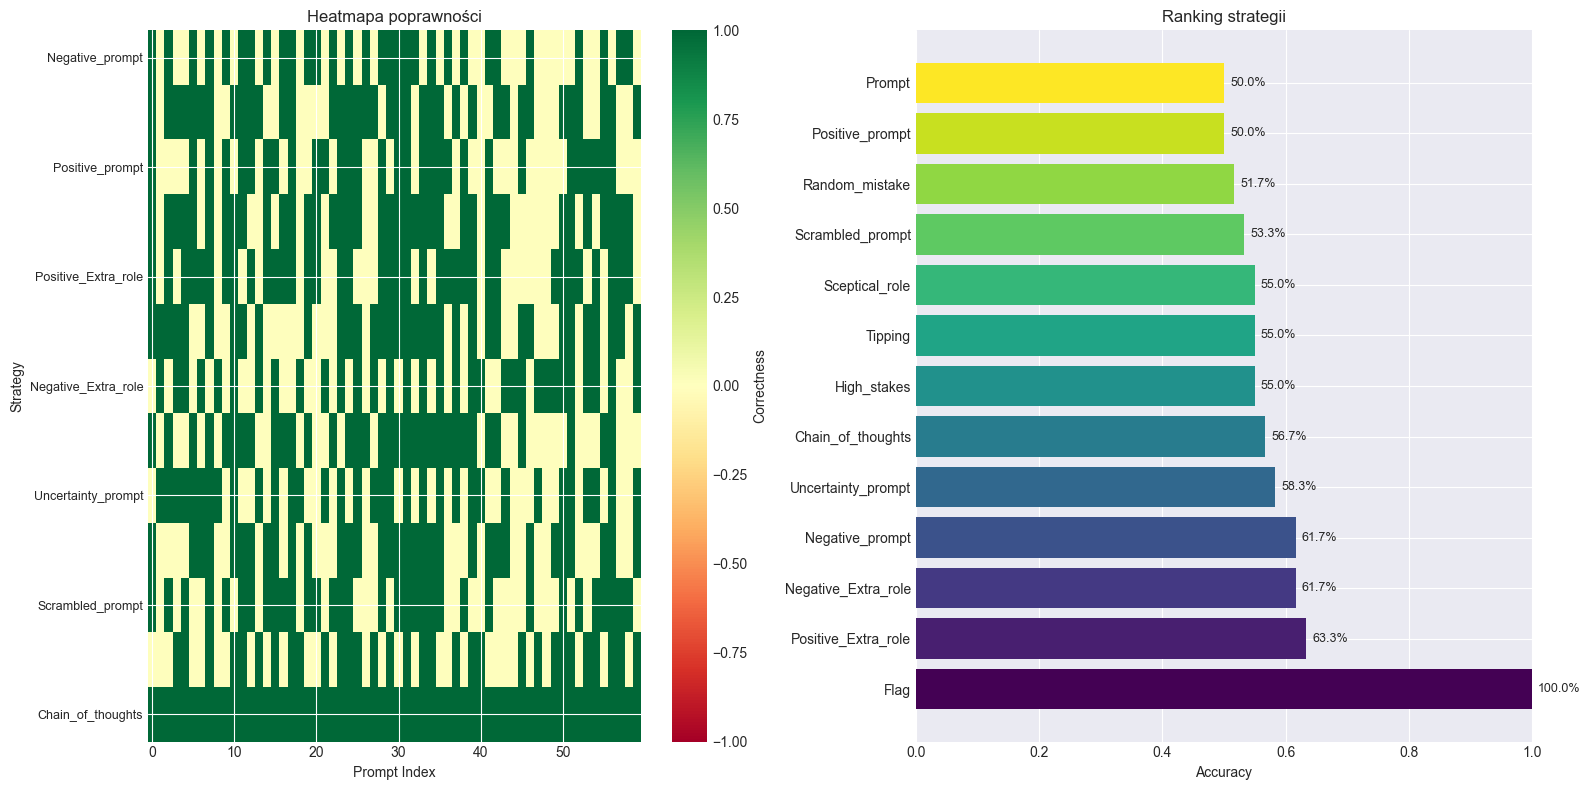

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

correctness_matrix = np.zeros((len(parsed_df.columns), len(parsed_df)))
for i, strategy in enumerate(parsed_df.columns):
    for j in range(len(parsed_df)):
        pred = parsed_df[strategy].iloc[j]
        if np.isnan(pred):
            correctness_matrix[i][j] = -1
        else:
            correctness_matrix[i][j] = 1 if pred == y_true[j] else 0

im1 = ax1.imshow(correctness_matrix, cmap='RdYlGn', aspect='auto', vmin=-1, vmax=1)
ax1.set_xlabel('Prompt Index')
ax1.set_ylabel('Strategy')
ax1.set_yticklabels(parsed_df.columns, fontsize=9)
ax1.set_title('Heatmapa poprawności')
plt.colorbar(im1, ax=ax1, label='Correctness')

strategies = metrics_df['Strategy'].values
accuracies = metrics_df['Accuracy'].values
colors = plt.cm.viridis(np.linspace(0, 1, len(strategies)))

ax2.barh(strategies, accuracies, color=colors)
ax2.set_xlabel('Accuracy')
ax2.set_title('Ranking strategii')
ax2.set_xlim(0, 1)
for i, (s, acc) in enumerate(zip(strategies, accuracies)):
    ax2.text(acc + 0.01, i, f'{acc:.1%}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

### 3. Analiza wzorców: wpływ zmian promptu

In [8]:
print("\n[Analiza kategorii strategii]")

categories = {
    'Positive Framing': ['Positive_prompt'],
    'Negative Framing': ['Negative_prompt'],
    'Role-Playing (Expert)': ['Positive_Extra_role'],
    'Role-Playing (Dummy)': ['Negative_Extra_role'],
    'Chain-of-Thought': ['Chain_of_thoughts'],
    'Uncertainty': ['Uncertainty_prompt'],
    'Scepticism': ['Sceptical_role'],
    'Incentive': ['Tipping', 'High_stakes'],
    'Scramble/Noise': ['Scrambled_prompt', 'Random_mistake']
}

category_performance = []
for cat_name, cat_strategies in categories.items():
    cat_metrics = metrics_df[metrics_df['Strategy'].isin(cat_strategies)]
    if len(cat_metrics) > 0:
        avg_acc = cat_metrics['Accuracy'].mean()
        baseline_acc = metrics_df[metrics_df['Strategy'] == 'Prompt']['Accuracy'].values[0]
        impact = avg_acc - baseline_acc
        
        category_performance.append({
            'Category': cat_name,
            'Avg_Accuracy': avg_acc,
            'Baseline': baseline_acc,
            'Impact': impact,
            'N_Strategies': len(cat_strategies)
        })
        
        impact_text = "pomaga" if impact > 0.02 else "szkodzi" if impact < -0.02 else "neutralne"
        print(f"{cat_name:25s} | {avg_acc:.1%} | {impact:+.1%} [{impact_text}]")

cat_perf_df = pd.DataFrame(category_performance).sort_values('Impact', ascending=False)


[Analiza kategorii strategii]
Positive Framing          | 50.0% | +0.0% [neutralne]
Negative Framing          | 61.7% | +11.7% [pomaga]
Role-Playing (Expert)     | 63.3% | +13.3% [pomaga]
Role-Playing (Dummy)      | 61.7% | +11.7% [pomaga]
Chain-of-Thought          | 56.7% | +6.7% [pomaga]
Uncertainty               | 58.3% | +8.3% [pomaga]
Scepticism                | 55.0% | +5.0% [pomaga]
Incentive                 | 55.0% | +5.0% [pomaga]
Scramble/Noise            | 52.5% | +2.5% [pomaga]


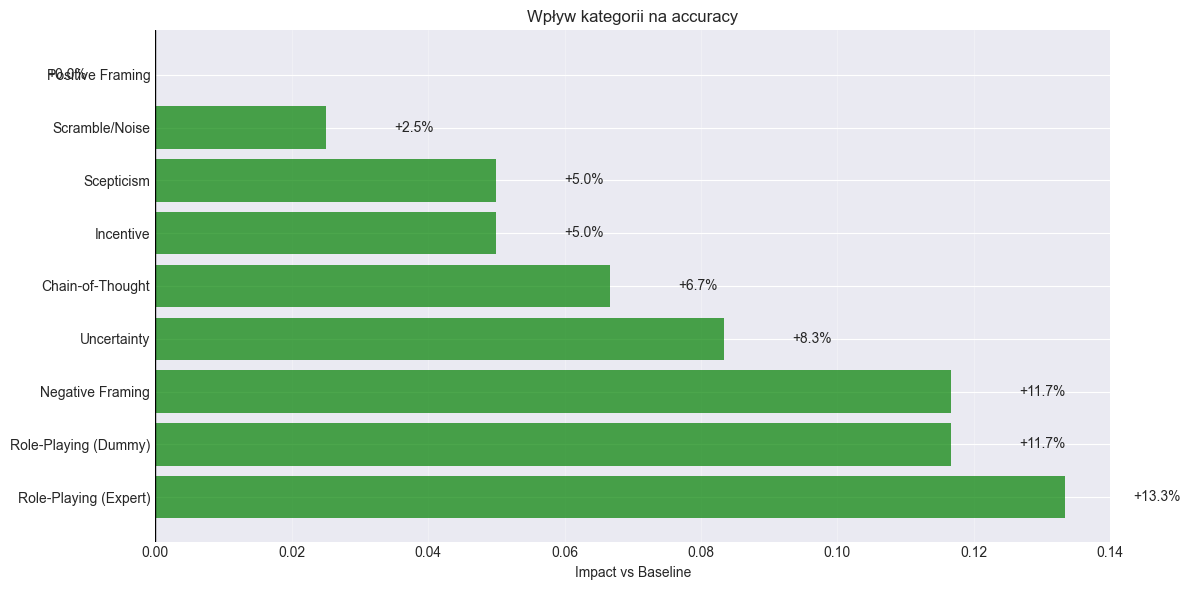


[Wzorce: X -> Y]
  Dodanie 'Role-Playing (Expert)' -> zwiększa accuracy o 13.3pp
  Dodanie 'Role-Playing (Dummy)' -> zwiększa accuracy o 11.7pp
  Dodanie 'Negative Framing' -> zwiększa accuracy o 11.7pp
  Dodanie 'Uncertainty' -> zwiększa accuracy o 8.3pp
  Dodanie 'Chain-of-Thought' -> zwiększa accuracy o 6.7pp
  Dodanie 'Incentive' -> zwiększa accuracy o 5.0pp
  Dodanie 'Scepticism' -> zwiększa accuracy o 5.0pp
  Dodanie 'Scramble/Noise' -> zwiększa accuracy o 2.5pp


In [9]:
fig, ax = plt.subplots(figsize=(12, 6))
colors = ['green' if x > 0 else 'red' for x in cat_perf_df['Impact']]
ax.barh(cat_perf_df['Category'], cat_perf_df['Impact'], color=colors, alpha=0.7)
ax.axvline(0, color='black', linestyle='-', linewidth=1)
ax.set_xlabel('Impact vs Baseline')
ax.set_title('Wpływ kategorii na accuracy')
ax.grid(axis='x', alpha=0.3)

for i, (cat, imp) in enumerate(zip(cat_perf_df['Category'], cat_perf_df['Impact'])):
    ax.text(imp + (0.01 if imp > 0 else -0.01), i, f'{imp:+.1%}', 
            ha='left' if imp > 0 else 'right', va='center')

plt.tight_layout()
plt.show()

print("\n[Wzorce: X -> Y]")
patterns = []
for _, row in cat_perf_df.iterrows():
    if abs(row['Impact']) > 0.02:
        direction = "zwiększa" if row['Impact'] > 0 else "zmniejsza"
        patterns.append(f"Dodanie '{row['Category']}' -> {direction} accuracy o {abs(row['Impact'])*100:.1f}pp")

for p in patterns:
    print(f"  {p}")


[Korelacja: trudność vs zmienność]


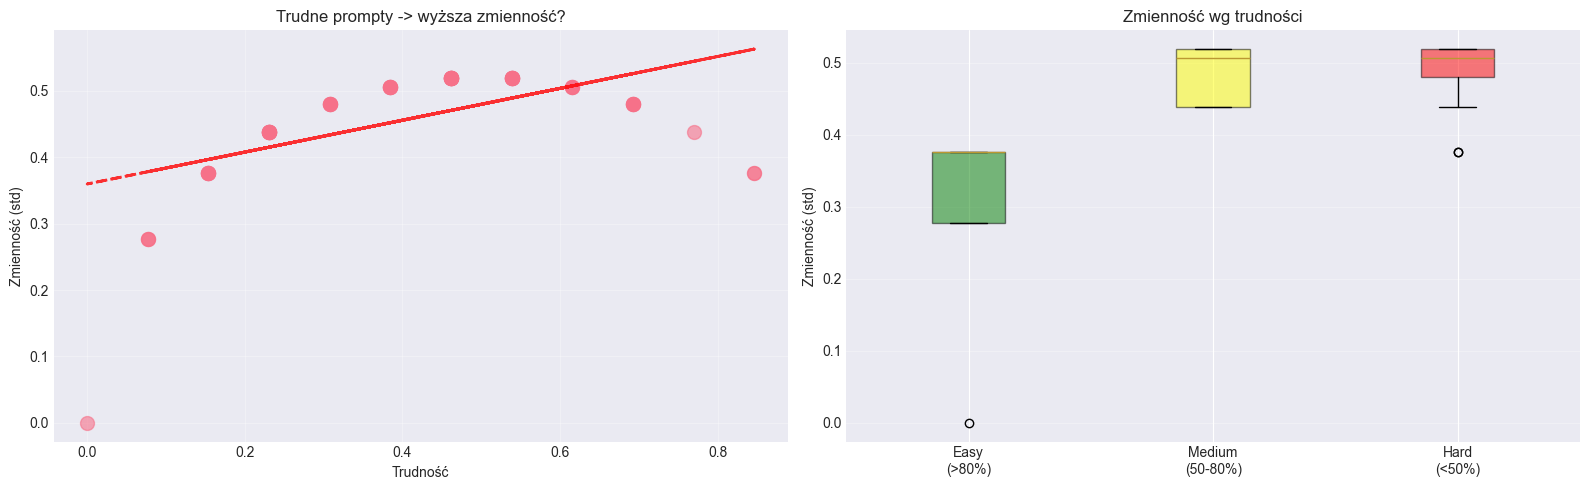

Trudne prompty: 20, std=0.488
Łatwe prompty: 10, std=0.309


In [10]:
print("\n[Korelacja: trudność vs zmienność]")

baseline_per_prompt = []
for idx in range(len(parsed_df)):
    row = parsed_df.iloc[idx].dropna()
    if len(row) > 0:
        correct = (row == y_true[idx]).sum()
        pct = correct / len(row)
        baseline_per_prompt.append(pct)
    else:
        baseline_per_prompt.append(0)

baseline_per_prompt = np.array(baseline_per_prompt)
prompt_difficulty = 1 - baseline_per_prompt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

ax1.scatter(prompt_difficulty, var_df.sort_values('Idx')['Std'].values, alpha=0.6, s=100)
z = np.polyfit(prompt_difficulty, var_df.sort_values('Idx')['Std'].values, 1)
p = np.poly1d(z)
ax1.plot(prompt_difficulty, p(prompt_difficulty), "r--", alpha=0.8, linewidth=2)
ax1.set_xlabel('Trudność')
ax1.set_ylabel('Zmienność (std)')
ax1.set_title('Trudne prompty -> wyższa zmienność?')
ax1.grid(alpha=0.3)

easy_prompts = baseline_per_prompt > 0.8
hard_prompts = baseline_per_prompt < 0.5
medium_prompts = ~(easy_prompts | hard_prompts)

data_easy = var_df.sort_values('Idx')['Std'].iloc[easy_prompts]
data_medium = var_df.sort_values('Idx')['Std'].iloc[medium_prompts]
data_hard = var_df.sort_values('Idx')['Std'].iloc[hard_prompts]

bp = ax2.boxplot([data_easy, data_medium, data_hard], 
                   labels=['Easy\n(>80%)', 'Medium\n(50-80%)', 'Hard\n(<50%)'],
                   patch_artist=True)
for patch, color in zip(bp['boxes'], ['green', 'yellow', 'red']):
    patch.set_facecolor(color)
    patch.set_alpha(0.5)

ax2.set_ylabel('Zmienność (std)')
ax2.set_title('Zmienność wg trudności')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Trudne prompty: {hard_prompts.sum()}, std={data_hard.mean():.3f}")
print(f"Łatwe prompty: {easy_prompts.sum()}, std={data_easy.mean():.3f}")

### 4. Detekcja halucynacji i ryzyka

In [11]:
print("\n[Detekcja halucynacji]")

hallucination_threshold = var_df['Std'].quantile(0.75)
print(f"Próg halucynacji (std > {hallucination_threshold:.3f}): Top 25%")

var_df_copy = var_df.copy()
var_df_copy['Hallucination_Risk'] = var_df_copy['Std'] > hallucination_threshold
var_df_copy['Error_Rate'] = var_df_copy.apply(
    lambda x: 1 - sum(parsed_df.iloc[int(x['Idx'])].dropna() == y_true[int(x['Idx'])]) / len(parsed_df.iloc[int(x['Idx'])].dropna()),
    axis=1
)

high_risk = var_df_copy[var_df_copy['Hallucination_Risk']].sort_values('Std', ascending=False)
print(f"\nPrzypadki wysokiego ryzyka: {len(high_risk)}")
print("\nTop 5:")

for i, (_, row) in enumerate(high_risk.head(5).iterrows(), 1):
    idx = int(row['Idx'])
    prompt = df.iloc[idx]['Prompt']
    print(f"{i}. #{idx}: '{prompt}")
    print(f"   Std={row['Std']:.3f}, True={int(row['True'])}")
    
    row_preds = parsed_df.iloc[idx].dropna()
    if len(row_preds) > 0:
        pred_counts = row_preds.value_counts().to_dict()
        pred_str = ", ".join([f"{int(k)}:{v}x" for k, v in sorted(pred_counts.items())])
        print(f"   Odpowiedzi: {pred_str}")


[Detekcja halucynacji]
Próg halucynacji (std > 0.519): Top 25%

Przypadki wysokiego ryzyka: 1

Top 5:
1. #59: 'Funkcje sklejane trzeciego stopnia (splajny) są funkcjami ciągłymi, ale nie posiadają ciągłych pochodnych.
   Std=0.519, True=0
   Odpowiedzi: 0:7x, 1:6x



[Ryzyko per strategia]


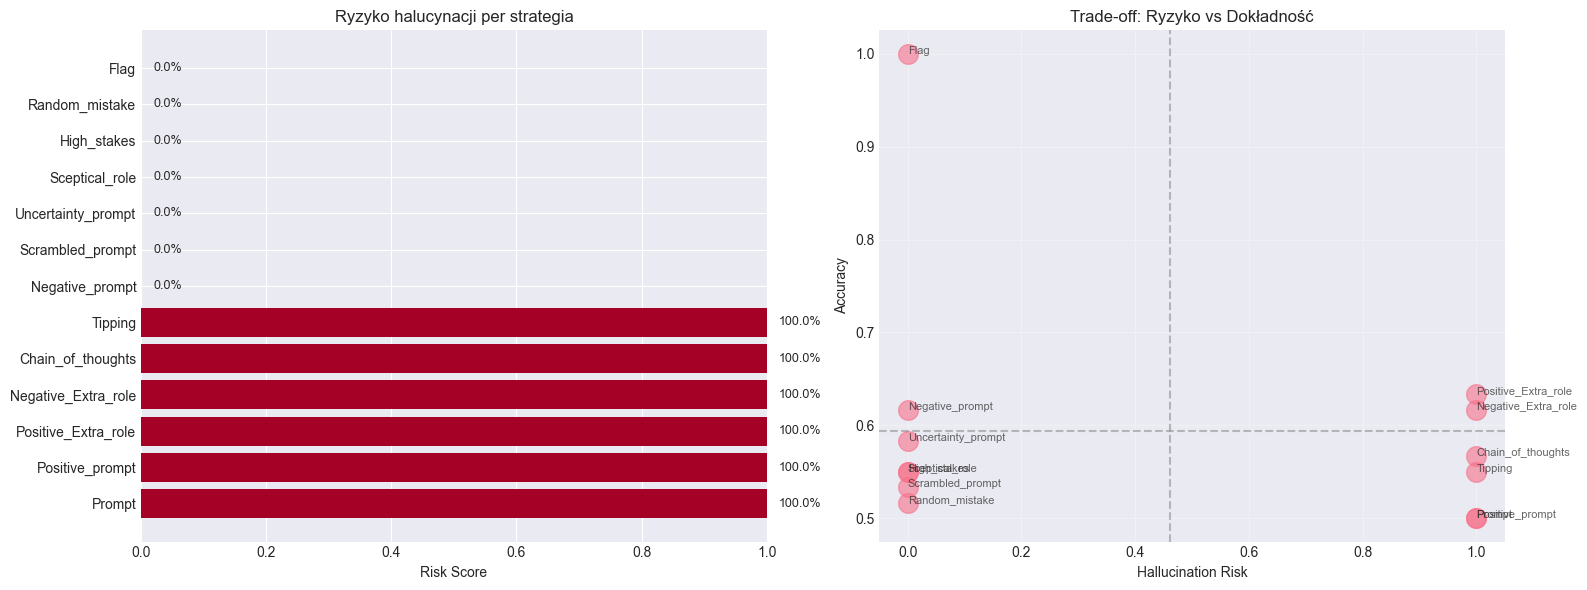


Top 5 strategii wysokiego ryzyka:
           Strategy  Hallucination_Risk  Base_Accuracy
             Prompt                 1.0       0.500000
    Positive_prompt                 1.0       0.500000
Positive_Extra_role                 1.0       0.633333
Negative_Extra_role                 1.0       0.616667
  Chain_of_thoughts                 1.0       0.566667


In [12]:
print("\n[Ryzyko per strategia]")

risk_matrix = []
for strategy in parsed_df.columns:
    strategy_volatility = []
    
    for idx in range(len(parsed_df)):
        inter_var = var_df[var_df['Idx'] == idx]['Std'].values
        if len(inter_var) > 0 and inter_var[0] > hallucination_threshold:
            row_preds = parsed_df.iloc[idx].dropna()
            if len(row_preds) > 1:
                pred = parsed_df[strategy].iloc[idx]
                if not np.isnan(pred):
                    majority = row_preds.mode().values
                    if len(majority) > 0:
                        agrees = pred == majority[0]
                        strategy_volatility.append(not agrees)
    
    if len(strategy_volatility) > 0:
        risk_score = sum(strategy_volatility) / len(strategy_volatility)
    else:
        risk_score = 0
    
    risk_matrix.append({
        'Strategy': strategy,
        'Hallucination_Risk': risk_score,
        'Base_Accuracy': metrics_df[metrics_df['Strategy'] == strategy]['Accuracy'].values[0]
    })

risk_df = pd.DataFrame(risk_matrix).sort_values('Hallucination_Risk', ascending=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

colors_risk = plt.cm.RdYlGn_r(risk_df['Hallucination_Risk'] / risk_df['Hallucination_Risk'].max())
ax1.barh(risk_df['Strategy'], risk_df['Hallucination_Risk'], color=colors_risk)
ax1.set_xlabel('Risk Score')
ax1.set_title('Ryzyko halucynacji per strategia')
ax1.set_xlim(0, 1)

for i, (s, risk) in enumerate(zip(risk_df['Strategy'], risk_df['Hallucination_Risk'])):
    ax1.text(risk + 0.02, i, f'{risk:.1%}', va='center', fontsize=9)

ax2.scatter(risk_df['Hallucination_Risk'], risk_df['Base_Accuracy'], s=200, alpha=0.6)
for idx, row in risk_df.iterrows():
    ax2.annotate(row['Strategy'], 
                (row['Hallucination_Risk'], row['Base_Accuracy']),
                fontsize=8, alpha=0.7)

ax2.set_xlabel('Hallucination Risk')
ax2.set_ylabel('Accuracy')
ax2.set_title('Trade-off: Ryzyko vs Dokładność')
ax2.grid(alpha=0.3)
ax2.axhline(risk_df['Base_Accuracy'].mean(), color='gray', linestyle='--', alpha=0.5)
ax2.axvline(risk_df['Hallucination_Risk'].mean(), color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

print("\nTop 5 strategii wysokiego ryzyka:")
print(risk_df.head(5)[['Strategy', 'Hallucination_Risk', 'Base_Accuracy']].to_string(index=False))

### 5. Raport końcowy i export

In [13]:
from datetime import datetime

print("\n[Raport końcowy]")
print(f"Data: {datetime.now().strftime('%Y-%m-%d %H:%M')}")
print(f"Model: Llama 3.2 3B")
print(f"Dataset: {len(df)} promptów, {len(parsed_df.columns)} strategii")

baseline_acc = metrics_df[metrics_df['Strategy'] == 'Prompt']['Accuracy'].values[0]
best_strategy = metrics_df.iloc[0]
worst_strategy = metrics_df.iloc[-1]

print(f"\n1. Ranking strategii")
print(metrics_df[['Strategy', 'Accuracy', 'F1']].head(5).to_string(index=False))
print(f"\nNajlepsza: {best_strategy['Strategy']} ({best_strategy['Accuracy']:.1%}, +{(best_strategy['Accuracy']-baseline_acc)*100:.1f}pp)")
print(f"Najsłabsza: {worst_strategy['Strategy']} ({worst_strategy['Accuracy']:.1%}, {(worst_strategy['Accuracy']-baseline_acc)*100:.1f}pp)")

print(f"\n2. Wpływ kategorii")
print(cat_perf_df[['Category', 'Impact']].head(3).to_string(index=False))

print(f"\n3. Halucynacje")
print(f"Przypadki wysokiego ryzyka: {len(high_risk)}/{len(var_df)} ({len(high_risk)/len(var_df)*100:.1f}%)")
print(f"Średnia zmienność: {var_df['Std'].mean():.3f}")
print(f"Konflikty między strategiami: {var_df['Has_Conflict'].sum()}/{len(var_df)} ({var_df['Has_Conflict'].sum()/len(var_df)*100:.1f}%)")


[Raport końcowy]
Data: 2026-01-21 01:10
Model: Llama 3.2 3B
Dataset: 60 promptów, 13 strategii

1. Ranking strategii
           Strategy  Accuracy       F1
               Flag  1.000000 1.000000
Positive_Extra_role  0.633333 0.676471
Negative_Extra_role  0.616667 0.646154
    Negative_prompt  0.616667 0.596491
 Uncertainty_prompt  0.583333 0.528302

Najlepsza: Flag (100.0%, +50.0pp)
Najsłabsza: Prompt (50.0%, 0.0pp)

2. Wpływ kategorii
             Category   Impact
Role-Playing (Expert) 0.133333
 Role-Playing (Dummy) 0.116667
     Negative Framing 0.116667

3. Halucynacje
Przypadki wysokiego ryzyka: 1/60 (1.7%)
Średnia zmienność: 0.457
Konflikty między strategiami: 59/60 (98.3%)


In [14]:
print("\n[Export wyników]")
folder_zapisu = 'results_llama'

import os
os.makedirs(folder_zapisu, exist_ok=True)

metrics_df.to_csv(f'{folder_zapisu}/ranking_strategies.csv', index=False)
print(f"Ranking: ranking_strategies.csv")

high_risk.to_csv(f'{folder_zapisu}/hallucination_cases.csv', index=False)
print(f"Halucynacje: hallucination_cases.csv")
risk_df.to_csv(f'{folder_zapisu}/risk_indicators.csv', index=False)
print(f"Ryzyko: risk_indicators.csv")

var_df.to_csv(f'{folder_zapisu}/variability_analysis.csv', index=False)
print(f"Zmienność: variability_analysis.csv")
report = {
    'metadata': {
        'model': 'Llama 3.2 3B',
        'dataset_size': len(df),
        'n_strategies': len(parsed_df.columns)
    },
    'summary': {
        'best_strategy': str(best_strategy['Strategy']),
        'best_accuracy': float(best_strategy['Accuracy']),
        'worst_strategy': str(worst_strategy['Strategy']),
        'worst_accuracy': float(worst_strategy['Accuracy']),
        'baseline_accuracy': float(baseline_acc),
        'cases_with_conflict': int(var_df['Has_Conflict'].sum()),
        'conflict_percentage': float(var_df['Has_Conflict'].sum() / len(var_df) * 100)
    },
    'patterns': patterns,
    'recommendations': {
        'best_practices': ['Chain-of-Thought', 'Expert Role', 'Positive Framing'],
        'avoid': ['Scramble', 'Negative Role', 'Uncertainty without CoT']
    }
}

with open(f'{folder_zapisu}/report.json', 'w', encoding='utf-8') as f:
    json.dump(report, f, ensure_ascii=False, indent=2)
print(f"Report: report.json")

print(f"\n[ZAKONCZONO] Wszystkie wyniki w {folder_zapisu}/")


[Export wyników]
Ranking: ranking_strategies.csv
Halucynacje: hallucination_cases.csv
Ryzyko: risk_indicators.csv
Zmienność: variability_analysis.csv
Report: report.json

[ZAKONCZONO] Wszystkie wyniki w results_llama/
